## Imports


Link (models): https://www.kaggle.com/code/mihailchirobocea/inference-diffusion-for-ffhq/edit/run/172323204

For training code, see: https://www.kaggle.com/code/mihailchirobocea/training-diffusion-for-ffhq

In [19]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms 
from torch.utils.data import DataLoader
from torch import optim
from torch.cuda.amp import autocast, GradScaler
from tqdm.notebook import tqdm
import copy
import numpy as np
import math
from PIL import Image
from matplotlib import pyplot as plt

!pip install --upgrade diffusers[torch]

from diffusers import DDPMScheduler, DDIMScheduler

## Model

In [7]:
class EMA():
    """
    Exponential Moving Average (EMA) class.

    Args:
        beta (float): The smoothing factor for the EMA calculation.
        step (int, optional): The current step. Defaults to 0.

    Methods:
        update_model_average(ema_model, current_model):
            Updates the model average using the EMA calculation.
        update_average(old, new):
            Calculates the EMA using the old and new values.
        step_ema(ema_model, model, step_start_ema=2000):
            Performs the EMA step, updating the model average if the step is greater than or equal to `step_start_ema`.
        reset_parameters(ema_model, model):
            Resets the parameters of the EMA model to match the original model.

    """

    def __init__(self, beta, step=0):
        super().__init__()
        self.beta = beta
        self.step = step

    def update_model_average(self, ema_model, current_model):
        """
        Updates the model average using the EMA calculation.

        Args:
            ema_model: The EMA model.
            current_model: The current model.

        """
        for current_params, ema_params in zip(current_model.parameters(), ema_model.parameters()):
            old_weight, up_weight = ema_params.data, current_params.data
            ema_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        """
        Calculates the EMA using the old and new values.

        Args:
            old: The old value.
            new: The new value.

        Returns:
            The EMA value.

        """
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        """
        Performs the EMA step, updating the model average if the step is greater than or equal to `step_start_ema`.

        Args:
            ema_model: The EMA model.
            model: The current model.
            step_start_ema (int, optional): The step at which to start updating the model average. Defaults to 2000.

        """
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        """
        Resets the parameters of the EMA model to match the original model.

        Args:
            ema_model: The EMA model.
            model: The original model.

        """
        ema_model.load_state_dict(model.state_dict())
        
        

class HeadAttention(nn.Module):
    """
    HeadAttention module applies multi-head attention mechanism to the input tensor.

    Args:
        channels (int): The number of input channels.

    Attributes:
        channels (int): The number of input channels.
        mha (nn.MultiheadAttention): The multi-head attention module.
        ln (nn.LayerNorm): The layer normalization module.
        ff_self (nn.Sequential): The feed-forward neural network module.

    """

    def __init__(self, channels):
        super(HeadAttention, self).__init__()
        self.channels = channels

        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        """
        Forward pass of the HeadAttention module.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor after applying multi-head attention mechanism.

        """
        h, w = x.shape[-2:]
        x = x.view(-1, self.channels, h * w).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, h, w)
    


class SkipAttention(nn.Module):
    """
    SkipAttention module applies skip attention mechanism to the input tensors.

    Args:
        f_in_g (int): Number of input channels for the g tensor.
        f_in_x (int): Number of input channels for the x tensor.
        f_out (int): Number of output channels.

    Attributes:
        w_g (nn.Sequential): Sequential module for processing the g tensor.
        w_x (nn.Sequential): Sequential module for processing the x tensor.
        relu (nn.ReLU): ReLU activation function.
        psi (nn.Sequential): Sequential module for processing the combined tensor.

    """

    def __init__(self, f_in_g, f_in_x, f_out):
        super().__init__()

        self.w_g = nn.Sequential(
            nn.Conv2d(f_in_g, f_out, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(f_out)
        )

        self.w_x = nn.Sequential(
            nn.Conv2d(f_in_x, f_out, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(f_out)
        )

        self.relu = nn.ReLU(inplace=True)

        self.psi = nn.Sequential(
            nn.Conv2d(f_out, 1, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, g, x):
        """
        Forward pass of the SkipAttention module.

        Args:
            g (torch.Tensor): Input tensor g.
            x (torch.Tensor): Input tensor x.

        Returns:
            torch.Tensor: Output tensor after applying skip attention mechanism.

        """
        g1 = self.w_g(g)
        x1 = self.w_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return psi * x
    
    
    
class DoubleConv(nn.Module):
    """
    DoubleConv module performs a double convolution operation on the input tensor.
    
    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        mid_channels (int, optional): Number of intermediate channels. If not provided, it is set to out_channels.
        residual (bool, optional): Whether to use residual connection. Defaults to False.
        emb_dim (int, optional): Dimension of the embedding layer. Defaults to 512.
    """
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False, emb_dim=512):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )
        
        self.emb_layer = nn.Linear(emb_dim, out_channels)

    def forward(self, x, t=None):
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor.
            t (torch.Tensor, optional): Target tensor. Defaults to None.

        Returns:
            torch.Tensor: Output tensor.
        """
        if self.residual:
            x = F.gelu(x + self.double_conv(x))
        else:
            x = self.double_conv(x)
        if t is not None:
            emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
            x = x + emb
        return x
        
class Down(nn.Module):
    """
    This class represents the Down module of a neural network.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        emb_dim (int, optional): Dimension of the embedding layer. Defaults to 512.
    """

    def __init__(self, in_channels, out_channels, emb_dim=512):
        super().__init__()

        self.down = nn.Conv2d(in_channels, in_channels, 4, stride=2, padding=1)
        
        self.conv1 = DoubleConv(in_channels, in_channels, residual=True)
        self.conv2 = DoubleConv(in_channels, out_channels)

        self.emb_layer = nn.Linear(emb_dim, out_channels)

        self.head_attention = HeadAttention(out_channels)

    def forward(self, x, t):
        """
        Forward pass of the Down module.

        Args:
            x (torch.Tensor): Input tensor.
            t (torch.Tensor): Embedding tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        x = self.down(x)
        x = self.conv1(x)
        x = self.conv2(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        x = x + emb
        x = self.head_attention(x)
        return x


class Up(nn.Module):
    """
    Up module of the network.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        gated_attention (bool): Whether to use gated attention.
        emb_dim (int, optional): Dimension of the embedding. Defaults to 512.
    """

    def __init__(self, in_channels, out_channels, gated_attention, emb_dim=512):
        super().__init__()

        self.gated_attention = gated_attention

        self.attention = SkipAttention(in_channels // 2, in_channels // 2, in_channels // 2)

        self.conv1 = DoubleConv(in_channels, in_channels, residual=True)
        self.conv2 = DoubleConv(in_channels, out_channels)

        self.up = nn.ConvTranspose2d(out_channels, out_channels, 4, stride=2, padding=1)

        self.emb_layer = nn.Linear(emb_dim, out_channels)
        
        self.head_attention = HeadAttention(out_channels)
        

    def forward(self, x, skip_x, t):
        """
        Forward pass of the Up module.

        Args:
            x (torch.Tensor): Input tensor.
            skip_x (torch.Tensor): Skip connection tensor.
            t (torch.Tensor): Embedding tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        
        if self.gated_attention:
            skip_x = self.attention(g=x, x=skip_x)
        
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        x = x + emb
        x = self.head_attention(x)
        x = self.up(x)
        return x
    
    
class In(nn.Module):
    """
    This class represents a module that performs operations on input tensors.

    Args:
        out_channels (int): The number of output channels.
        in_channels (int, optional): The number of input channels. Defaults to 3.
        emb_dim (int, optional): The dimension of the embedding. Defaults to 512.
    """

    def __init__(self, out_channels, in_channels=3, emb_dim=512):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.GroupNorm(1, out_channels),
            nn.GELU(),
        )
        self.conv2 = DoubleConv(out_channels, out_channels, residual=True)

        self.emb_layer = nn.Linear(emb_dim, out_channels)

    def forward(self, x, t):
        """
        Performs a forward pass of the module.

        Args:
            x (torch.Tensor): The input tensor.
            t (torch.Tensor): The embedding tensor.

        Returns:
            torch.Tensor: The output tensor.
        """
        x = self.conv1(x)
        x = self.conv2(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        x = x + emb
        return x
    
    
class Out(nn.Module):
    """
    This class represents the output module of a neural network.

    Args:
        in_channels (int): Number of input channels.
        gated_attention (bool): Whether to use gated attention or not.
        out_channels (int, optional): Number of output channels. Defaults to 3.
        emb_dim (int, optional): Dimension of the embedding. Defaults to 512.
    """

    def __init__(self, in_channels, gated_attention, out_channels=3, emb_dim=512):
        super().__init__()
        
        self.gated_attention = gated_attention

        self.attention = SkipAttention(in_channels // 2, in_channels // 2, in_channels // 2)
        
        self.conv1 = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=True),
        )

    def forward(self, x, skip_x):
        """
        Forward pass of the output module.

        Args:
            x (torch.Tensor): Input tensor.
            skip_x (torch.Tensor): Skip connection tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        if self.gated_attention:
            skip_x = self.attention(g=x, x=skip_x)
        
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv1(x)
        return x
    
    
class UNet(nn.Module):
    """
    UNet is a convolutional neural network architecture used for image to image tasks.

    Args:
        device (torch.device): The device on which the model will be run.
        gated_attention (bool, optional): Whether to use gated attention mechanism. Defaults to False.
        c_in (int, optional): Number of input channels. Defaults to 3.
        c_out (int, optional): Number of output channels. Defaults to 3.
        time_dim (int, optional): Dimension of the time encoding. Defaults to 512.
    """

    def __init__(self, device, gated_attention=False, c_in=3, c_out=3, time_dim=512):
        super().__init__()

        self.channels = [128 * k for k in range(1, 5)]
        self.device = device
        self.time_dim = time_dim

        self.inc = In(self.channels[0])

        self.down1 = Down(self.channels[0], self.channels[1])
        self.down2 = Down(self.channels[1], self.channels[2])
        self.down3 = Down(self.channels[2], self.channels[3])

        self.bot1 = DoubleConv(self.channels[3], self.channels[3], residual=True)
        self.bot2 = DoubleConv(self.channels[3], self.channels[3], residual=True)
        self.bot3 = DoubleConv(self.channels[3], self.channels[3], residual=True)
        self.bot4 = DoubleConv(self.channels[3], self.channels[3], residual=True)
        self.bot5 = DoubleConv(self.channels[3], self.channels[3], residual=True)

        self.up1 = Up(2 * self.channels[3], self.channels[2], gated_attention)
        self.up2 = Up(2 * self.channels[2], self.channels[1], gated_attention)
        self.up3 = Up(2 * self.channels[1], self.channels[0], gated_attention)

        self.outc = Out(2 * self.channels[0], gated_attention)

    def pos_encoding(self, t, channels):
        """
        Generate positional encoding for the given time steps.

        Args:
            t (torch.Tensor): Time steps.
            channels (int): Number of channels.

        Returns:
            torch.Tensor: Positional encoding.
        """
        inv_freq = 1.0 / (10000 ** (torch.arange(0, channels, 2, device=self.device).float() / channels))
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        """
        Forward pass of the UNet model.

        Args:
            x (torch.Tensor): Input tensor.
            t (torch.Tensor): Time steps.

        Returns:
            torch.Tensor: Output tensor.
        """
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x, t)
        x2 = self.down1(x1, t)
        x3 = self.down2(x2, t)
        x4 = self.down3(x3, t)

        x5 = self.bot1(x4, t=t)
        x5 = self.bot2(x5, t=t)
        x5 = self.bot3(x5, t=t)
        x5 = self.bot4(x5, t=t)
        x5 = self.bot5(x5, t=t)

        x = self.up1(x5, x4, t)
        x = self.up2(x, x3, t)
        x = self.up3(x, x2, t)
        x = self.outc(x, x1)

        return x

## Diffusion

In [23]:
def save_images(images, b):
    """
    Save images to disk.

    Args:
        images (numpy.ndarray): Array of images.
        b (int): Value of b.

    Returns:
        None
    """
    for k in range(images.shape[0]):
        name = '50'
        img = Image.fromarray(images[k].permute(1, 2, 0).to('cpu').numpy())
        img.save(f"{name}_{b}_{k+1}.jpg")

    # Plot all images after saving (no upscaling)


    n = images.shape[0]
    h, w = images.shape[2], images.shape[3]
    rows = math.ceil(n / b)
    
    # Set figure size to match the actual pixel size (dpi controls resolution)
    dpi = 100
    figsize = (w * b / dpi, h * rows / dpi)
    plt.figure(figsize=figsize, dpi=dpi)

    for k in range(n):
        img = images[k].permute(1, 2, 0).to('cpu').numpy()
        plt.subplot(rows, b, k + 1)
        plt.imshow(img)
        plt.axis("off")

    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()



class Diffusion:
    """
    A class representing a diffusion process.

    Args:
        device (torch.device): The device to run the diffusion process on.
        noise_steps (int): The number of noise steps in the diffusion process.
        beta_start (float): The starting value of beta in the noise schedule.
        beta_end (float): The ending value of beta in the noise schedule.
        img_size (int): The size of the input images.

    Attributes:
        noise_steps (int): The number of noise steps in the diffusion process.
        beta_start (float): The starting value of beta in the noise schedule.
        beta_end (float): The ending value of beta in the noise schedule.
        img_size (int): The size of the input images.
        device (torch.device): The device to run the diffusion process on.
        beta (torch.Tensor): The noise schedule for beta values.
        alpha (torch.Tensor): The complement of the beta values in the noise schedule.
        alpha_hat (torch.Tensor): The cumulative product of the alpha values.

    Methods:
        prepare_noise_schedule(): Prepares the noise schedule for beta values.
        noise_images(x, t): Generates noise images for a given input image and time step.
        sample_timesteps(n): Samples random time steps for diffusion sampling.
        sample(model, scheduler, n, b): Performs diffusion sampling using a given model and scheduler.

    """

    def __init__(self, device, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=64):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        """
        Prepares the noise schedule for beta values.

        Returns:
            torch.Tensor: The noise schedule for beta values.

        """
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        """
        Generates noise images for a given input image and time step.

        Args:
            x (torch.Tensor): The input image.
            t (int): The time step.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: The noise image and the noise.

        """
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        """
        Samples random time steps for diffusion sampling.

        Args:
            n (int): The number of time steps to sample.

        Returns:
            torch.Tensor: The sampled time steps.

        """
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, scheduler, n, b):
        """
        Performs diffusion sampling using a given model and scheduler.

        Args:
            model: The model to use for diffusion sampling.
            scheduler: The scheduler to use for diffusion sampling.
            n (int): The number of samples to generate.
            b: The batch size.

        Returns:
            None

        """
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)

            for i, t in enumerate(tqdm(scheduler.timesteps, total=len(scheduler.timesteps))):
                t = t.repeat(n)
                noise_pred = model(x, t)
                x = scheduler.step(noise_pred, t[0], x).prev_sample

        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        save_images(x, b)
        return


## Inference

In [17]:
def sample_diffusion_images(batch = 1, no = 1, total_img = 10, path = "/kaggle/input/ffhq-checkpoints/my_diff_ffhq_v5_e73.pth"):
    """
    Sample diffusion images using a pre-trained UNet model.

    This function loads a pre-trained UNet model, loads a checkpoint, and performs diffusion sampling
    to generate a specified number of images. The images are sampled using a scheduler and a batch size.

    Args:
        batch (int, optional): The batch size for sampling the images. Defaults to 1.
        no (int, optional): The starting index for the sampled images. Defaults to 1.
        total_img (int, optional): The total number of images to be sampled. Defaults to 10.
        path (str, optional): The path to the pre-trained model checkpoint. Defaults to "/kaggle/input/ffhq-checkpoints/my_diff_ffhq_v5_e73.pth".

    Returns:
        None
    """
    device = 'cpu'

    model = UNet(device, gated_attention=True).to(device)
    model.eval()
    
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    diff = Diffusion(device)

    scheduler = DDIMScheduler()
    scheduler.set_timesteps(50)


    while no <= total_img // batch:
        print(no)
        diff.sample(model, scheduler, batch, no)
        no += 1


/tmp/ipykernel_31/2997237582.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


1


  0%|          | 0/50 [00:00<?, ?it/s]

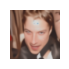

2


  0%|          | 0/50 [00:00<?, ?it/s]

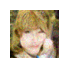

3


  0%|          | 0/50 [00:00<?, ?it/s]

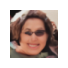

4


  0%|          | 0/50 [00:00<?, ?it/s]

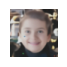

5


  0%|          | 0/50 [00:00<?, ?it/s]

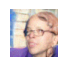

6


  0%|          | 0/50 [00:00<?, ?it/s]

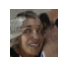

7


  0%|          | 0/50 [00:00<?, ?it/s]

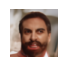

8


  0%|          | 0/50 [00:00<?, ?it/s]

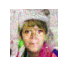

9


  0%|          | 0/50 [00:00<?, ?it/s]

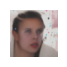

10


  0%|          | 0/50 [00:00<?, ?it/s]

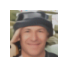

In [24]:
sample_diffusion_images()